# Diffusion Model Toy Example

Attempting to reimplement _Denoising Diffusion Probabilistic Model_ (Ho et al. (2020)).

Battle plan:

* Agree on target distribution --> Sklearn "digits"
* ~~Generate~~ Load target distribution
* PyTorch for the NN
* Network implementation $\mu_\theta$
* Implement Algorithm 1 (Training)
* Train until convergence
* Implement Algorithm 2 (Sampling)
* Sample examples
* Evaluation through manual inspection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import torch
from torch import Tensor
from tqdm import tqdm

Data loading and inspection

In [2]:
dataset = sklearn.datasets.load_digits()
data_np, labels_np = dataset['data'], dataset['target']
data_np = data_np[labels_np <= 2]
del labels_np
data = torch.from_numpy(data_np.astype(np.float32))
data = ((data / 15) - 0.5) * 2  # Normalize between [-1, 1]
IMG_DIM = data.shape[1]
data.shape, data.dtype

(torch.Size([537, 64]), torch.float32)

In [3]:
def imshow(x: Tensor) -> None:
    plt.imshow(x.reshape((8, 8)));

In [4]:
data_sample = data[0]
data_sample

tensor([-1.0000, -1.0000, -0.3333,  0.7333,  0.2000, -0.8667, -1.0000, -1.0000,
        -1.0000, -1.0000,  0.7333,  1.0000,  0.3333,  1.0000, -0.3333, -1.0000,
        -1.0000, -0.6000,  1.0000, -0.7333, -1.0000,  0.4667,  0.0667, -1.0000,
        -1.0000, -0.4667,  0.6000, -1.0000, -1.0000,  0.0667,  0.0667, -1.0000,
        -1.0000, -0.3333,  0.0667, -1.0000, -1.0000,  0.2000,  0.0667, -1.0000,
        -1.0000, -0.4667,  0.4667, -1.0000, -0.8667,  0.6000, -0.0667, -1.0000,
        -1.0000, -0.7333,  0.8667, -0.3333,  0.3333,  0.6000, -1.0000, -1.0000,
        -1.0000, -1.0000, -0.2000,  0.7333,  0.3333, -1.0000, -1.0000, -1.0000])

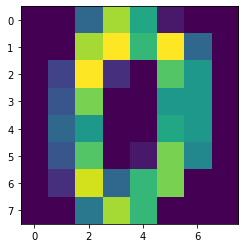

In [5]:
imshow(data_sample)

### Model Definition

Output size is equal to the input size, i.e., 64 units.

In [6]:
# Number of diffusion steps.
T = 100

In [7]:
# Won the race against ReLU.
ACTIVATION_FN = torch.nn.SiLU

In [8]:
class MuTheta(torch.nn.Module):
    def __init__(self, T: int):
        super().__init__()
        self.T = T
        self.mu_theta = torch.nn.Sequential(
            torch.nn.Linear(in_features=IMG_DIM+1, out_features=10),
            ACTIVATION_FN(),
            torch.nn.Linear(in_features=10, out_features=10),
            ACTIVATION_FN(),
            torch.nn.Linear(in_features=10, out_features=IMG_DIM))
        
    def forward(self, img: Tensor, t: int) -> Tensor:
        """img is a flat vector (possibly batched), t is a scalar"""
        t_scaled = self._scale_t(t)
        model_input = torch.concat([img, t_scaled], axis=-1)
        return self.mu_theta(model_input)
    
    def _scale_t(self, t: int) -> Tensor:
        return torch.tensor([(t / self.T - 0.5) * 2])

In [9]:
mu_theta = MuTheta(T=T)

Analyzing the deep image prior...

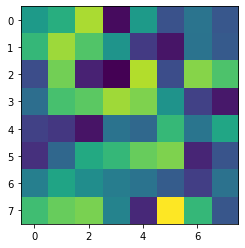

In [10]:
y = mu_theta(img=data_sample, t=0)
imshow(y.detach())

Paper values: $\beta_1=10^{-4}$ and $\beta_T=0.02$

In [11]:
beta_1 = 4.5e-5
beta_T = beta_1 * 20

In [12]:
beta_t = torch.linspace(beta_1, beta_T, T)
alpha_t = 1 - beta_t
alpha_bar_t = torch.tensor([torch.prod(alpha_t[:s]) for s in range(1, T+1)])

def beta(t: int) -> float:
    assert 0 < t <= T
    return beta_t[t-1]

def alpha(t: int) -> float:
    assert 0 < t <= T
    return alpha_t[t-1]

def alpha_bar(t: int) -> float:
    if t == 0: return alpha_bar_t[0]
    assert 0 < t <= T
    return alpha_bar_t[t-1]

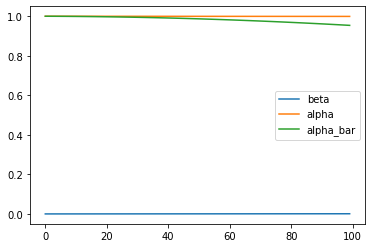

In [13]:
plt.plot(beta_t, label='beta')
plt.plot(alpha_t, label='alpha')
plt.plot(alpha_bar_t, label='alpha_bar')
plt.legend();

### Diffusion Process

(Aka. nosification.) **Eq. (4)** – the closed for of the iterative version in Eq. (2).

In [14]:
def q(x_0: Tensor, t: int) -> Tensor:
    """Implementatin of Eq. (4)."""
    std_normal = torch.randn(x_0.shape)
    mean = torch.sqrt(alpha_bar(t)) * x_0
    var = 1 - alpha_bar(t)
    return mean + std_normal * var.sqrt()

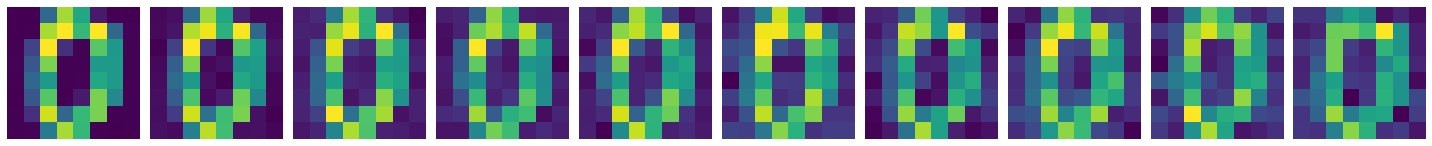

In [15]:
fig, ax = plt.subplots(1, 10, figsize=(20, 8))
ax = ax.flatten()

for i, t in enumerate(range(1, T, T // 10)):
    x_t = q(data_sample, t)
    
    ax[i].imshow(x_t.reshape((8, 8)))
    ax[i].axis('off')

plt.tight_layout()

### Reverse Process

(Aka. image generation.) The **term above Eq. (8)**, that is their implementation of Eq. (1). $\sigma$ is modeled as $=\beta$ (not a neural network).

They mention two possible choices for $\sigma_t^2$. We choose the simpler one.

In [16]:
sigma_squared_t = beta_t
sigma_squared = beta  # sigma_squared(t) = beta(t)

In [17]:
def p_theta(x_t: Tensor, t: int) -> Tensor:
    """p_theta(x_t-1|x_t)"""
    std_normal = torch.randn(x_t.shape)
    mu_theta_pred = mu_theta(img=x_t, t=t)
    var = sigma_squared(t)
    y = mu_theta_pred + std_normal * var.sqrt()
    return y

In [18]:
p_theta(x_t=data_sample, t=t)

tensor([ 0.0612,  0.1765,  0.3113, -0.2392,  0.0595, -0.1192, -0.0589, -0.2028,
         0.1561,  0.2951,  0.1654,  0.0473, -0.1668, -0.2842, -0.0825, -0.1393,
        -0.1683,  0.2495, -0.2511, -0.3802,  0.2652, -0.1173,  0.2802,  0.1939,
        -0.0895,  0.1626,  0.1759,  0.3202,  0.2600, -0.0349, -0.1986, -0.2432,
        -0.1802, -0.2161, -0.2548, -0.0557, -0.0882,  0.1965, -0.0688,  0.0882,
        -0.2458, -0.0932,  0.1249,  0.1552,  0.2284,  0.2298, -0.2100, -0.1505,
        -0.0319,  0.0870, -0.0108, -0.0366, -0.0378, -0.1186, -0.2374, -0.0616,
         0.1317,  0.2658,  0.2010, -0.0006, -0.2430,  0.3341,  0.1198, -0.1315],
       grad_fn=<AddBackward0>)

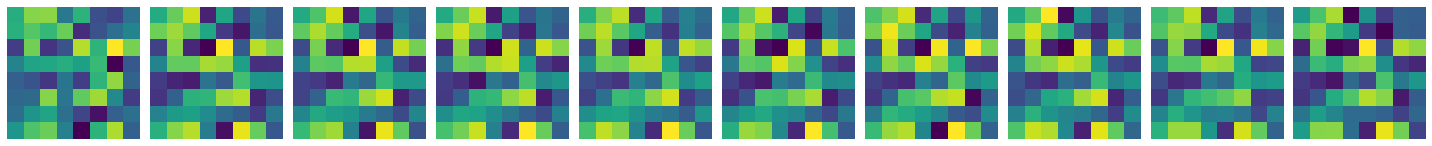

In [19]:
fig, ax = plt.subplots(1, 10, figsize=(20, 8))
ax = ax.flatten()

x_i = torch.randn(data_sample.shape)
for i, t in enumerate(range(1, T, T // 10)):
    x_i = p_theta(x_t=x_i, t=t).detach()
    
    ax[i].imshow(x_i.reshape((8, 8)))
    ax[i].axis('off')

plt.tight_layout()

### Loss Definition

Determining the mean $\tilde\mu_t$ of the diffusion process. **Eq. (7)**

In [20]:
def mu_tilde(x_t: Tensor, x_0: Tensor, t: int) -> Tensor:
    summand1 = (alpha_bar(t-1).sqrt() * beta(t)) / (1 - alpha_bar(t)) * x_0
    summand2 = (alpha(t).sqrt() * (1 - alpha_bar(t-1))) / (1 - alpha_bar(t)) * x_t
    return summand1 + summand2

**Equation above Eq. (9)**. Applying the reparameterization trick to sample from Eq. (4), i.e., $q_t(x_t\mid x_0)$.

In [21]:
def x_t(x_0: Tensor, t: int) -> Tensor:
    eps = torch.randn(x_0.shape)
    return alpha_bar(t).sqrt() + (1 - alpha_bar(t)).sqrt() * eps

In [22]:
mu_tilde(x_t(data_sample, 90), data_sample, 90)

tensor([1.1733, 1.0190, 1.0237, 0.7749, 1.1565, 1.0864, 0.9665, 0.7956, 0.9596,
        0.8153, 1.1152, 0.8053, 0.8236, 0.9088, 1.0931, 0.8129, 0.7021, 0.9178,
        1.0964, 1.2415, 0.9211, 1.1106, 1.0204, 0.8605, 0.9991, 1.1669, 0.8685,
        0.9817, 1.2692, 1.1251, 1.1573, 0.9710, 1.3518, 1.2266, 0.9455, 0.6366,
        0.9247, 1.3428, 1.0094, 0.5141, 0.8855, 0.7879, 0.6936, 1.0670, 0.9905,
        1.0376, 1.2846, 0.9962, 0.8565, 0.6987, 0.8484, 1.2244, 0.8307, 0.7907,
        1.2697, 0.8671, 0.8155, 1.1105, 1.3058, 0.8723, 1.2831, 0.9397, 0.8525,
        0.6944])

Loss function $L_{t-1}$ from **Eq. (8)**.

~~_Preferring the L2 norm over the Frobenius norm for computation efficiency._~~

In [23]:
def L(mu_tilde: Tensor, mu_theta: Tensor) -> Tensor:
    # Potentially risky (see "High Performance Python [Onomatopoeia], 2nd Edition")
    return 1 / (2 * sigma_squared(t)) * torch.linalg.norm(mu_tilde - mu_theta, ord=2) ** 2

In [35]:
NUM_MC_SAMPLES_X_T = 10
NUM_MC_SAMPLES_T = 1

def train_loss(net: torch.nn.Module, x_0: Tensor) -> Tensor:
    loss_sum = torch.tensor(0.)
    
    for t in torch.randint(1, T+1, size=(NUM_MC_SAMPLES_T,)):
        
        # Use multiple Monte Carlo samples to estimate the expected value over q in Eq. (8).
        loss_t_minus_1 = torch.tensor(0.)
        for _ in range(NUM_MC_SAMPLES_X_T):
            x_t_sample = x_t(x_0, t)
            mu_theta_val = net(img=x_t_sample, t=t)
            mu_tilde_val = mu_tilde(x_t_sample, x_0, t)
            l_tmp = L(mu_tilde_val, mu_theta_val)
            loss_t_minus_1 += l_tmp
        loss_sum += loss_t_minus_1 / NUM_MC_SAMPLES_X_T
        
    return loss_sum / NUM_MC_SAMPLES_T

### Training

In [36]:
NUM_EPOCHS = 100
LR = .003
WARM_START_EPOCHS = 10

torch.manual_seed(124)
mu_theta = MuTheta(T=T)

# Important update of Adam's beta_2 (might not work otherwise). ;-)
opt = torch.optim.Adam(mu_theta.parameters(), lr=1e-12, betas=(0.9, 0.996))
ll = []

for epoch in tqdm(range(1, NUM_EPOCHS+1)):
    opt.zero_grad()
    
    if epoch == WARM_START_EPOCHS:
        opt.param_groups[0]['lr'] = LR
    
    loss = torch.tensor(0.)
    for x_0 in data:
        loss += train_loss(mu_theta, x_0)
    loss /= len(data)
    ll.append(loss.item())
    
    loss.backward()
    opt.step()

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:24<00:00,  2.04s/it]


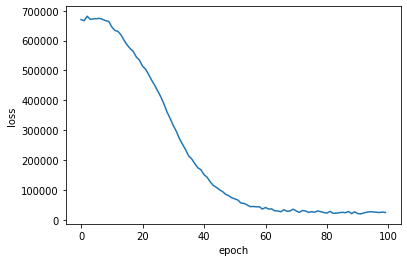

In [37]:
plt.plot(ll)
plt.xlabel('epoch')
plt.ylabel('loss');

### Inference

**Algorithm 2 (Sampling)** (except we predict $\mu$ not $\epsilon$)

In [38]:
x_T = torch.randn(data_sample.shape)
x_i = x_T
x_is = [x_T.view((8, 8))]
for i, t in tqdm(enumerate(range(T, 0, -1))):
    x_i = p_theta(x_t=x_i, t=t).detach()
    
    if t % 10 == 0:
        x_is.append(x_i.reshape((8, 8)))

100it [00:00, 8556.31it/s]


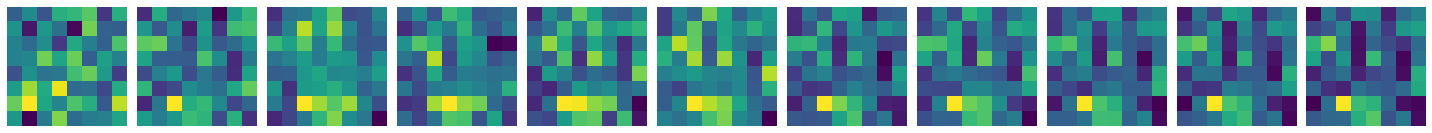

In [39]:
fig, ax = plt.subplots(1, len(x_is), figsize=(20, 8))
ax = ax.flatten()

for i, x_i in enumerate(x_is):
    ax[i].imshow(x_i)
    ax[i].axis('off')

plt.tight_layout()

In [40]:
x_T = torch.randn(data_sample.shape)
x_i = x_T
x_is = [x_T.view((8, 8))]
for i, t in tqdm(enumerate(range(T, 0, -1))):
    x_i = p_theta(x_t=x_i, t=t).detach()
    
    if t % 10 == 0:
        x_is.append(x_i.reshape((8, 8)))

100it [00:00, 13881.07it/s]


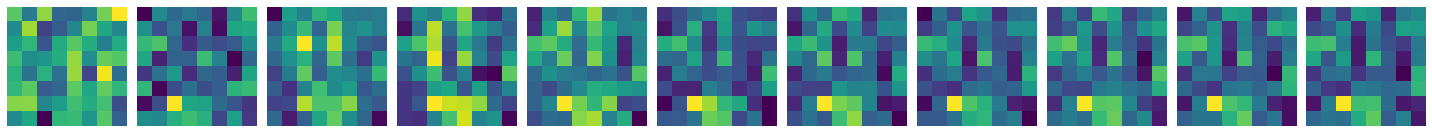

In [41]:
fig, ax = plt.subplots(1, len(x_is), figsize=(20, 8))
ax = ax.flatten()

for i, x_i in enumerate(x_is):
    ax[i].imshow(x_i)
    ax[i].axis('off')

plt.tight_layout()

### Todos

* Implement Algorithm 1 (and forget what we've done so far)
* Hparam tuning is tricky because our loss can be made arbitrarily (?) low by changing the betas.
* Data scaling